# Normalizing Flow Example: Real NVP

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EmoryMLIP/DeepGenerativeModelingIntro/blob/main/examples/RealNVP.ipynb)

## Some References

- Original work by [Dinh, Laurent and Sohl-Dickstein, Jascha and Bengio, Samy (2016)](https://arxiv.org/abs/1605.08803)
- Similar tutorial by [Arsenii Senya Ashukha](https://github.com/senya-ashukha/real-nvp-pytorch)
- Section 3.1 of our paper  [Introduction to Deep Generative Modeling](https://arxiv.org/abs/2103.05180)

## Short Mathematical Description

We train the generator by minimizing the negative log-likelihood of the samples:

\begin{equation}
    \newcommand{\bftheta}{\boldsymbol{\theta}}
    \newcommand{\bfx}{\mathbf{x}}
    \newcommand{\bfz}{\mathbf{z}}
    \newcommand{\bfy}{\mathbf{y}}
\min_{\bftheta}  \frac{1}{s} \sum_{i=1}^s \left( {\frac{1}{2}}\left\| g_{\bftheta}^{-1}\left(\bfx^{(i)}\right)\right\|^2 - \log\det\nabla  g_{\bftheta}^{-1}\left(\bfx^{(i)}\right) \right),
\end{equation}
where $\bfx^{(1)}, \ldots$ are sampled i.i.d. from the data distribution. Here, the idea is to use a generator like
\begin{equation*}
    g_{\bftheta}(\bfz) = f_K \circ f_{K-1} \circ \cdots \circ f_1(\bfz)
\end{equation*}
to obtain a tractable inverse and log-determinant.

In [23]:
# install requirements  (Colab only)
import sys,os
if 'google.colab' in sys.modules:
    dgm_dir = '/content/DeepGenerativeModelingIntro/'
    if not os.path.exists(dgm_dir):
        !git clone git://github.com/EmoryMLIP/DeepGenerativeModelingIntro.git

    sys.path.append(os.path.dirname(dgm_dir))

In [24]:
import torch
from torch import nn
import numpy as np
from torch import distributions
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'image.interpolation' : None})
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.dpi'] = 200

## Some suggested experiments

1. reduce the widths of the moon shapes so that the intrinsic dimensionality reduces to one
1. try the other dataset or create your own more challenging distribution
1. vary the hyperparameters (learning rate, number of layers, width, ...) and see how the performance changes
1. (for later as this takes more time) use a different layer with tractable inverse and log-determinant

## Setup the Dataset and Plotting

Text(0.5, 1.0, 'dataset: uniform $\\mathbf{x}^{(i)}$')

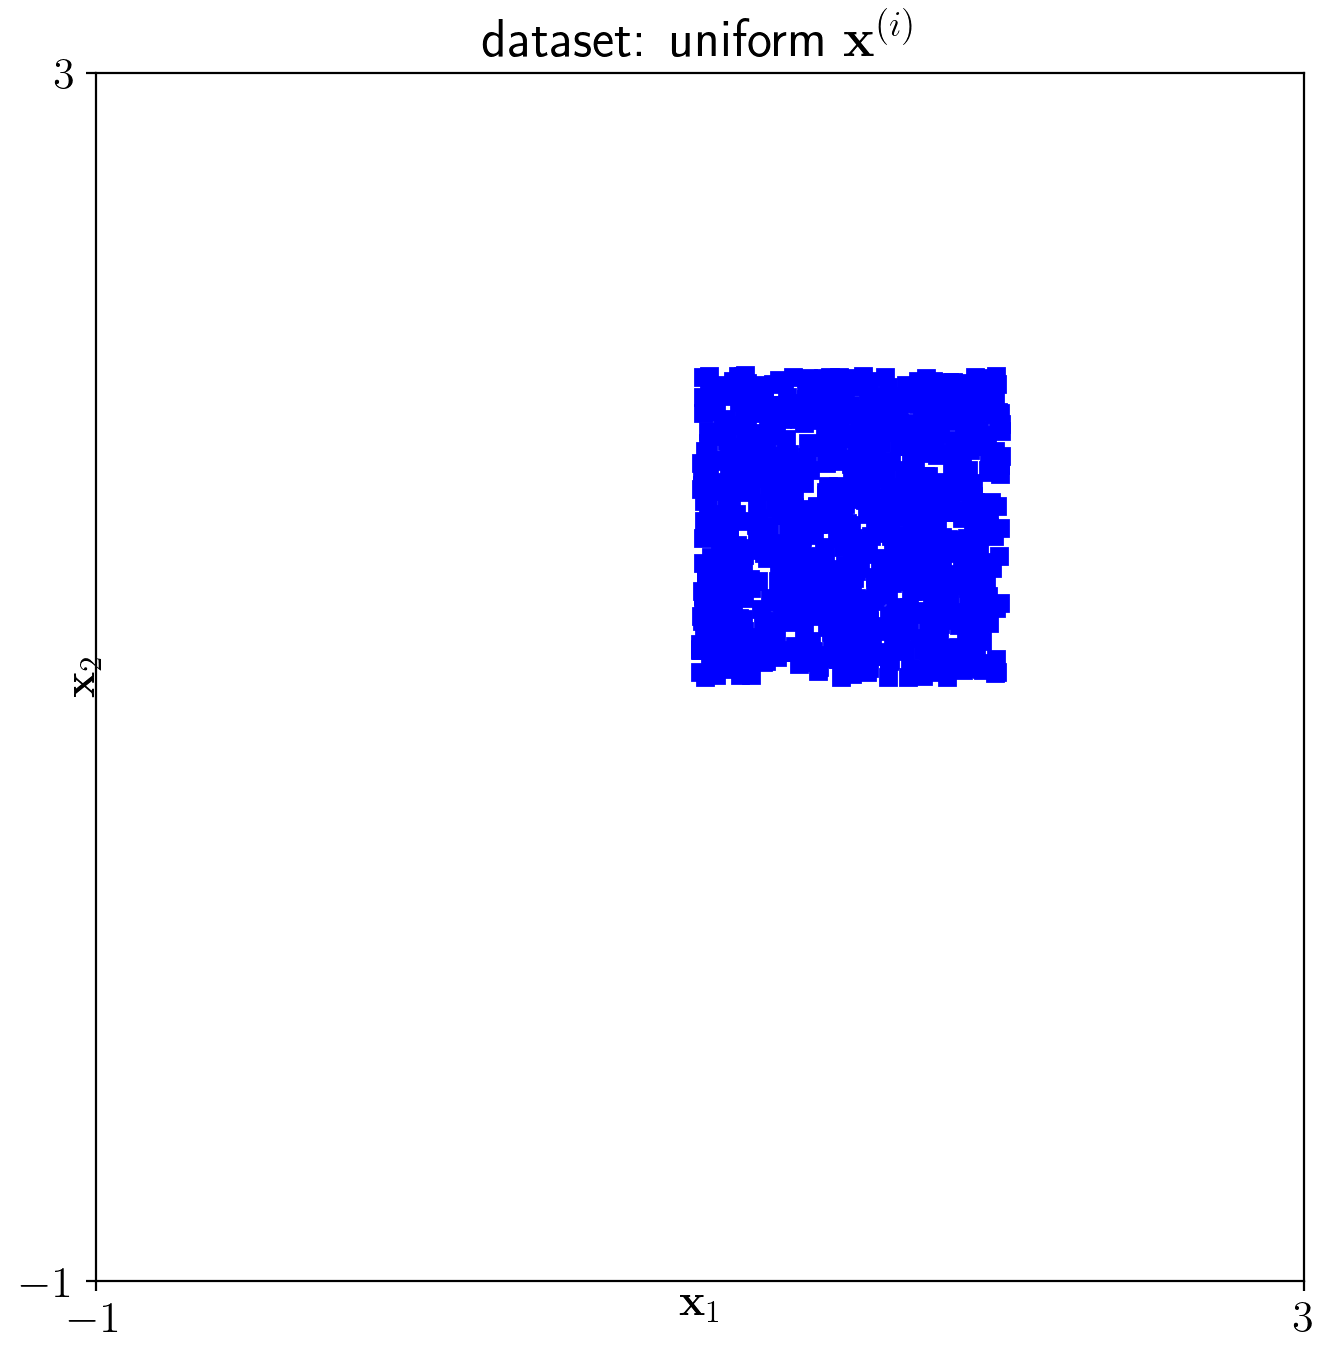

In [25]:
dataset = 'moons'
# dataset = 'uniform'

if dataset == 'moons':
    # grid of the spatial domain (for plotting)
    domain = (-1.2, 2.1, -1.2, 2.1)

    def get_data(batch_size,noise=0.05):
        return torch.tensor(datasets.make_moons(n_samples=batch_size, noise=noise)[0], dtype=torch.float32)
elif dataset == 'uniform':
    domain = (-1.0, 3.0, -1.0, 3.0)
    def get_data(batch_size):
        return torch.rand((batch_size,2)) + 1.0
else:
    print("incorrect dataset")

# grid of the spatial domain (for plotting)
x1 = torch.linspace(domain[0],domain[1], 100)
x2 = torch.linspace(domain[2],domain[3], 100)
xg = torch.meshgrid(x1, x2)
xx = torch.cat((xg[0].reshape(-1, 1), xg[1].reshape(-1, 1)), 1)

from plotting import *

xs = get_data(1000)
plot_x(xs,domain)
plt.title("dataset: %s" % (dataset))

## Choose the Network Architecture

We write the generator as

\begin{equation*}
    \newcommand{\bftheta}{\boldsymbol{\theta}}
	\newcommand{\bfz}{\mathbf{z}}
	\newcommand{\bfy}{\mathbf{y}}
	\newcommand{\bfm}{\mathbf{m}}
	g_{\bftheta}(\bfz) = f_K \circ f_{K-1} \circ \cdots \circ f_1(\bfz)
\end{equation*}

Here we are using the Real NVP layer

\begin{equation*}
f_j\left(\bfy^{(j)}\right) = \bfm^{(j)} \odot \bfy^{(j)} + (1-\bfm^{(j)}) \odot \left(y^{(j)} \odot \exp\left(s( \bfy^{(j)} \odot \bfm^{(j)})\right) + t\left(\bfy^{(j)} \odot \bfm^{(j)}\right)\right),
\end{equation*}

where $\bfm^{j} \in \{0,1\}^n$ is used to mask some components of the inputs. Below, we alternate between the first and second coordinate.

In [26]:
width = 128   # width of neural net layers
K = 6         # number of layers

from realNVP import NF, RealNVPLayer

layers = torch.nn.ModuleList()
for k in range(K):
    m = torch.tensor([1 - (k % 2), k % 2])
    t = nn.Sequential(nn.Linear(2, width), nn.LeakyReLU(), nn.Linear(width, width), nn.LeakyReLU(), nn.Linear(width, 2),
                      nn.Tanh())
    s = nn.Sequential(nn.Linear(2, width), nn.LeakyReLU(), nn.Linear(width, width), nn.LeakyReLU(), nn.Linear(width, 2),
                      nn.Tanh())
    layer = RealNVPLayer(s, t, m)
    layers.append(layer)

prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = NF(layers, prior)

## Train the Generator

Here, we use ADAM, a stochastic approximation scheme that operates on minibatches.

------ K=6, width=128, batch_size=256, num_steps=10000------
   step       J_ML    
001000   -5.0168e+00  
002000   -5.8390e+00  
003000   -5.8698e+00  
004000   -5.8846e+00  
005000   -5.8916e+00  
006000   -5.8968e+00  
007000   -5.8993e+00  
008000   -5.9021e+00  
009000   -5.9036e+00  
010000   -5.9055e+00  


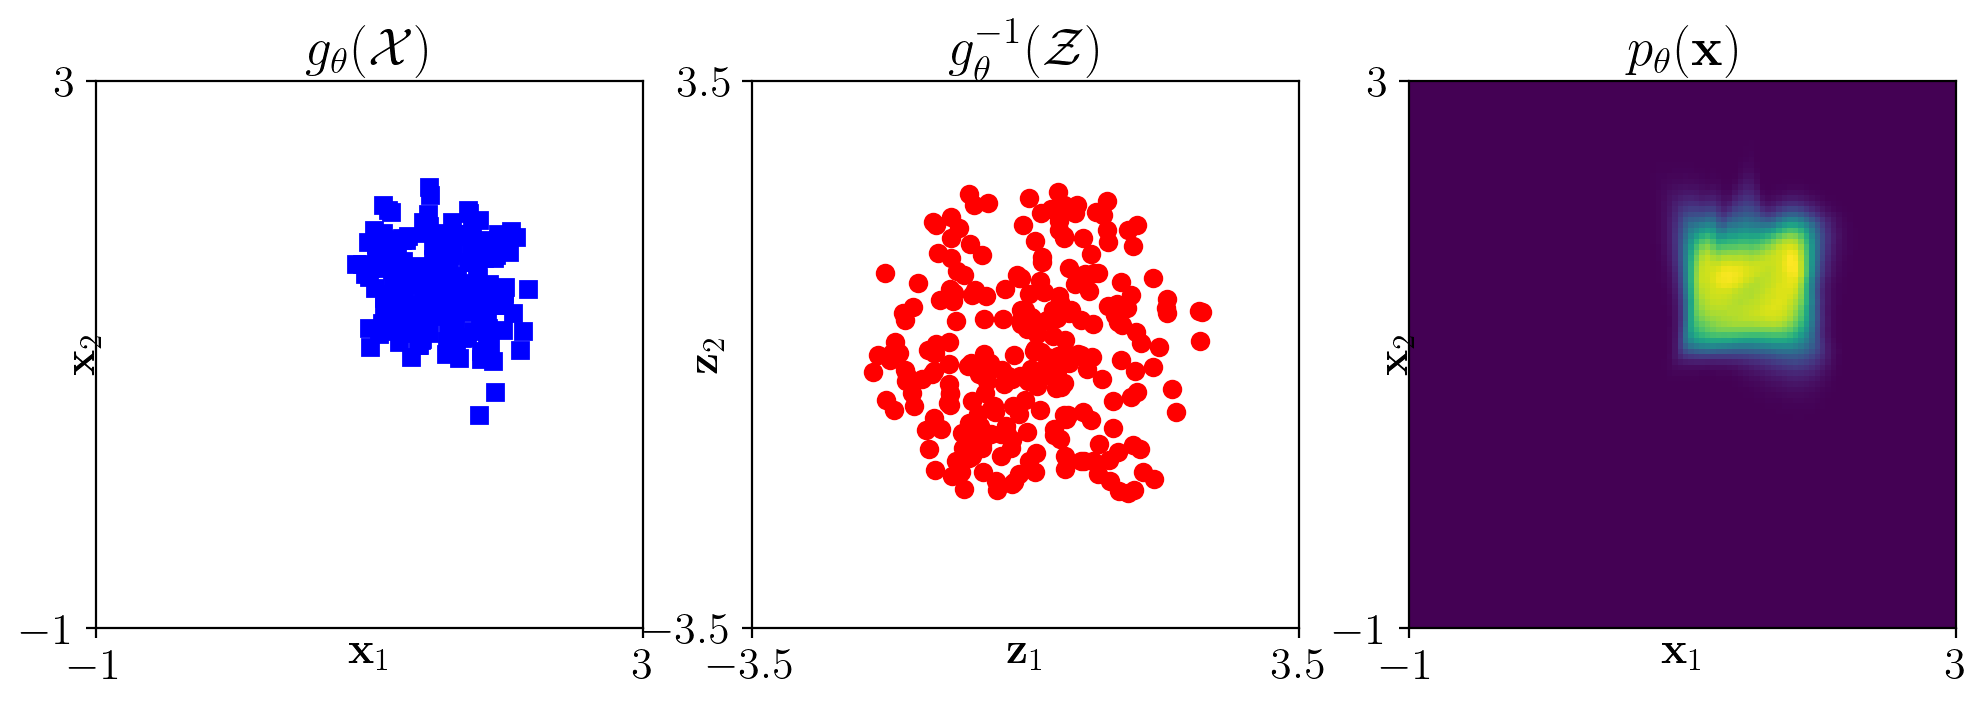

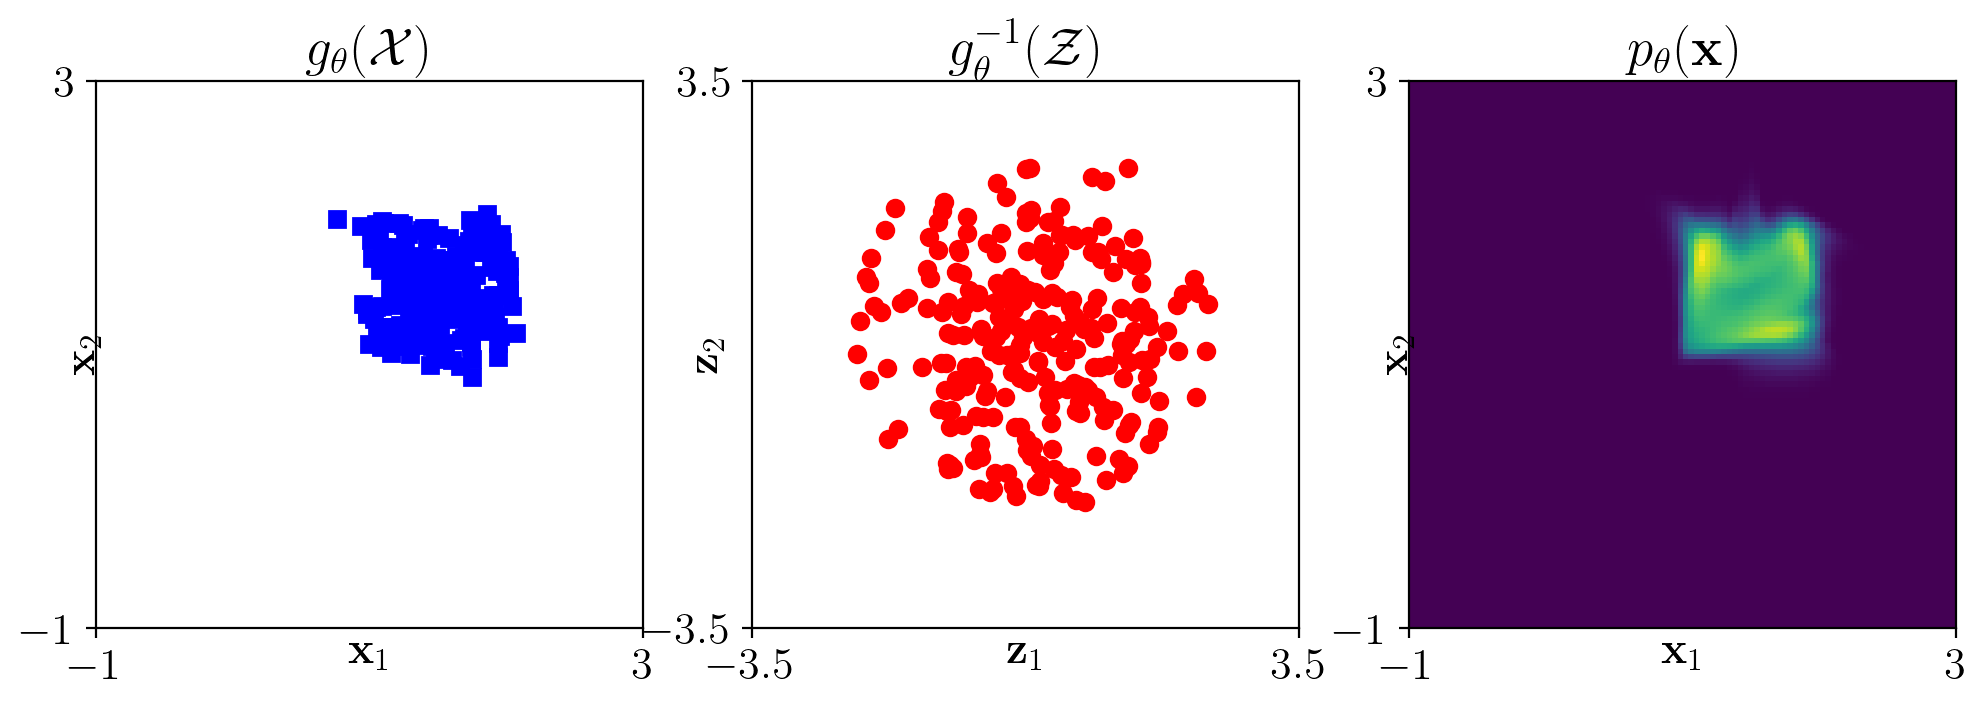

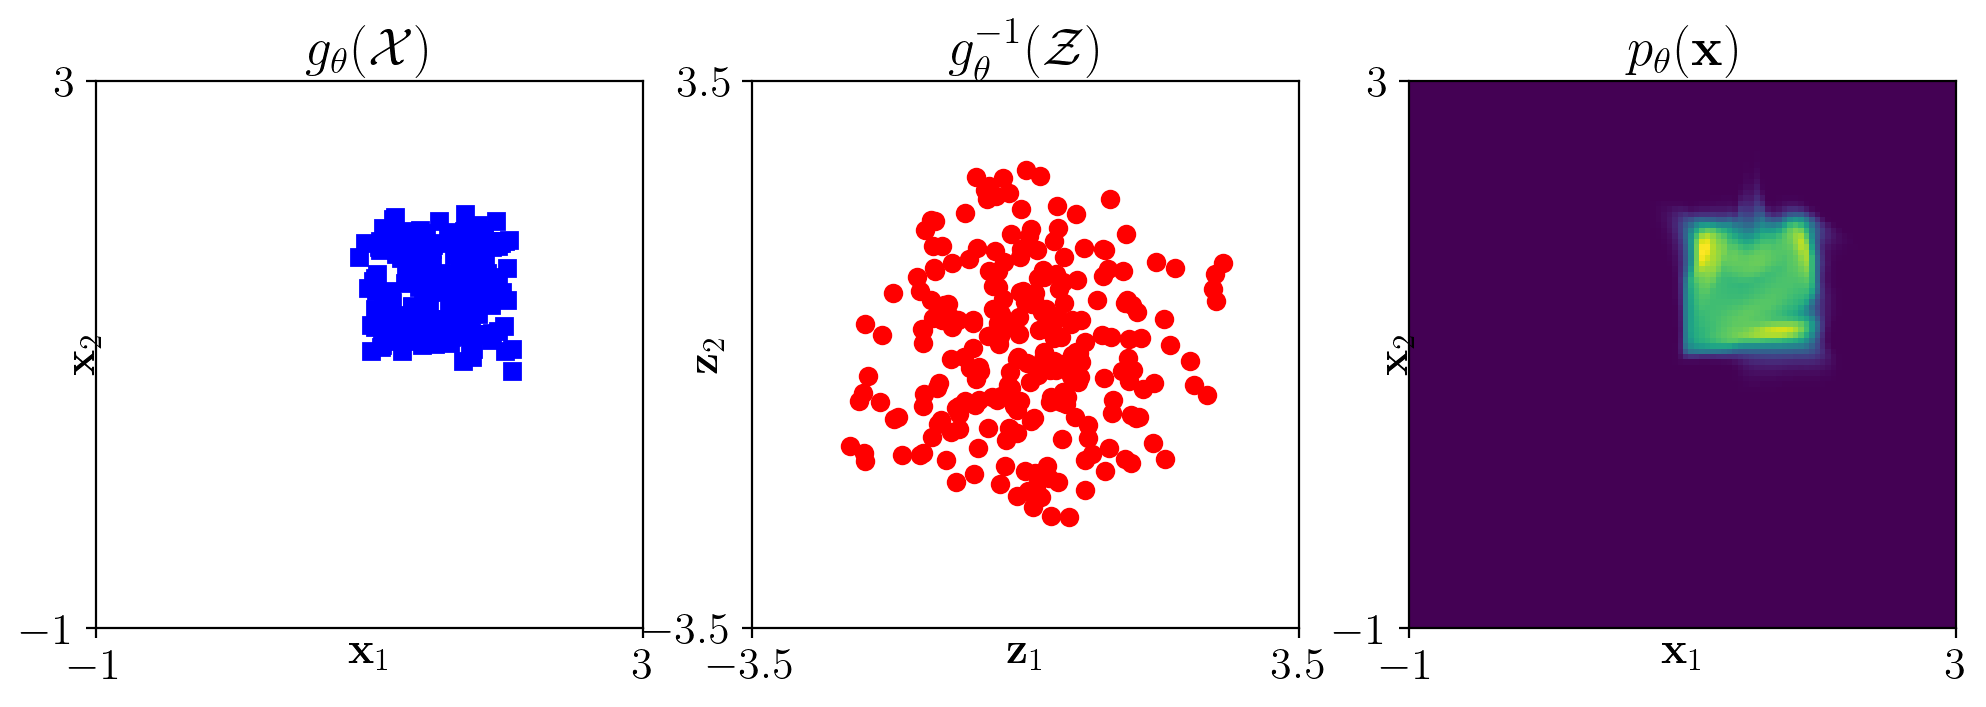

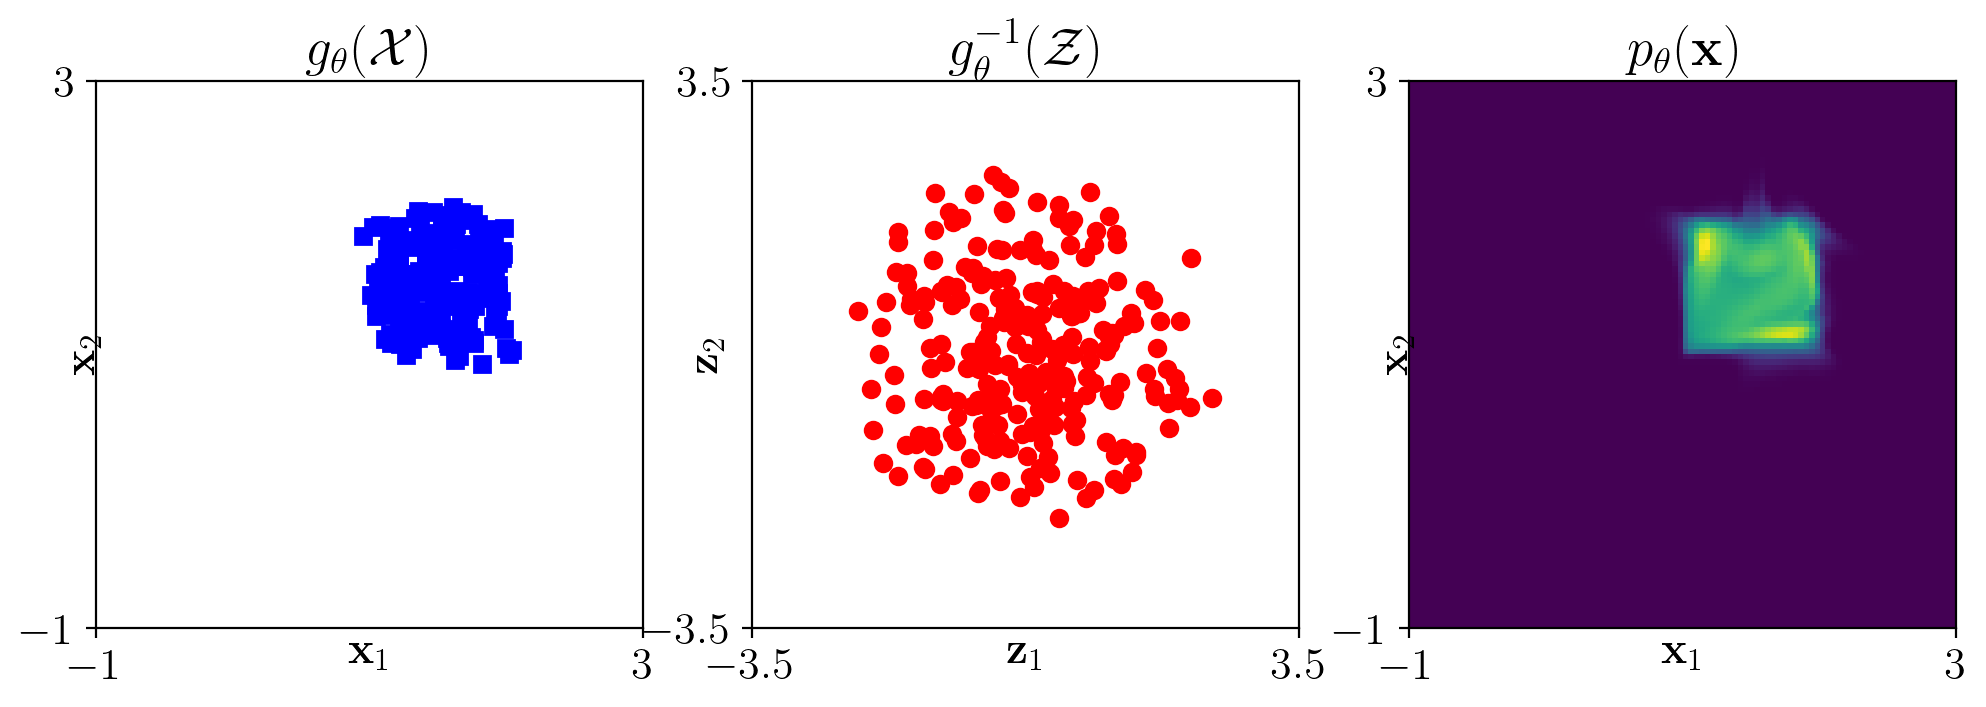

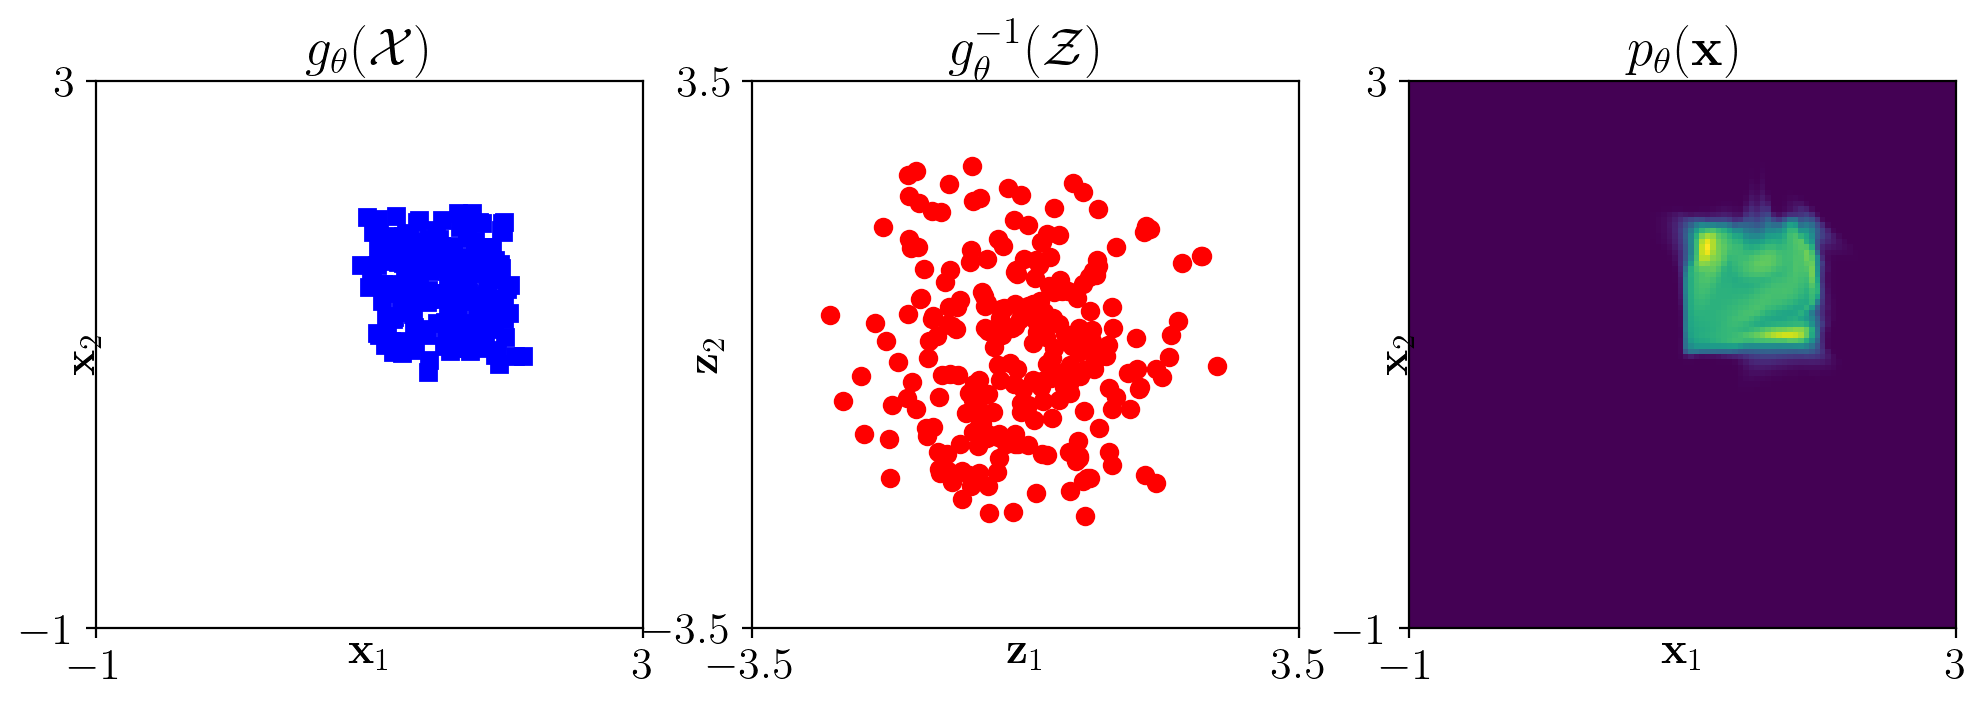

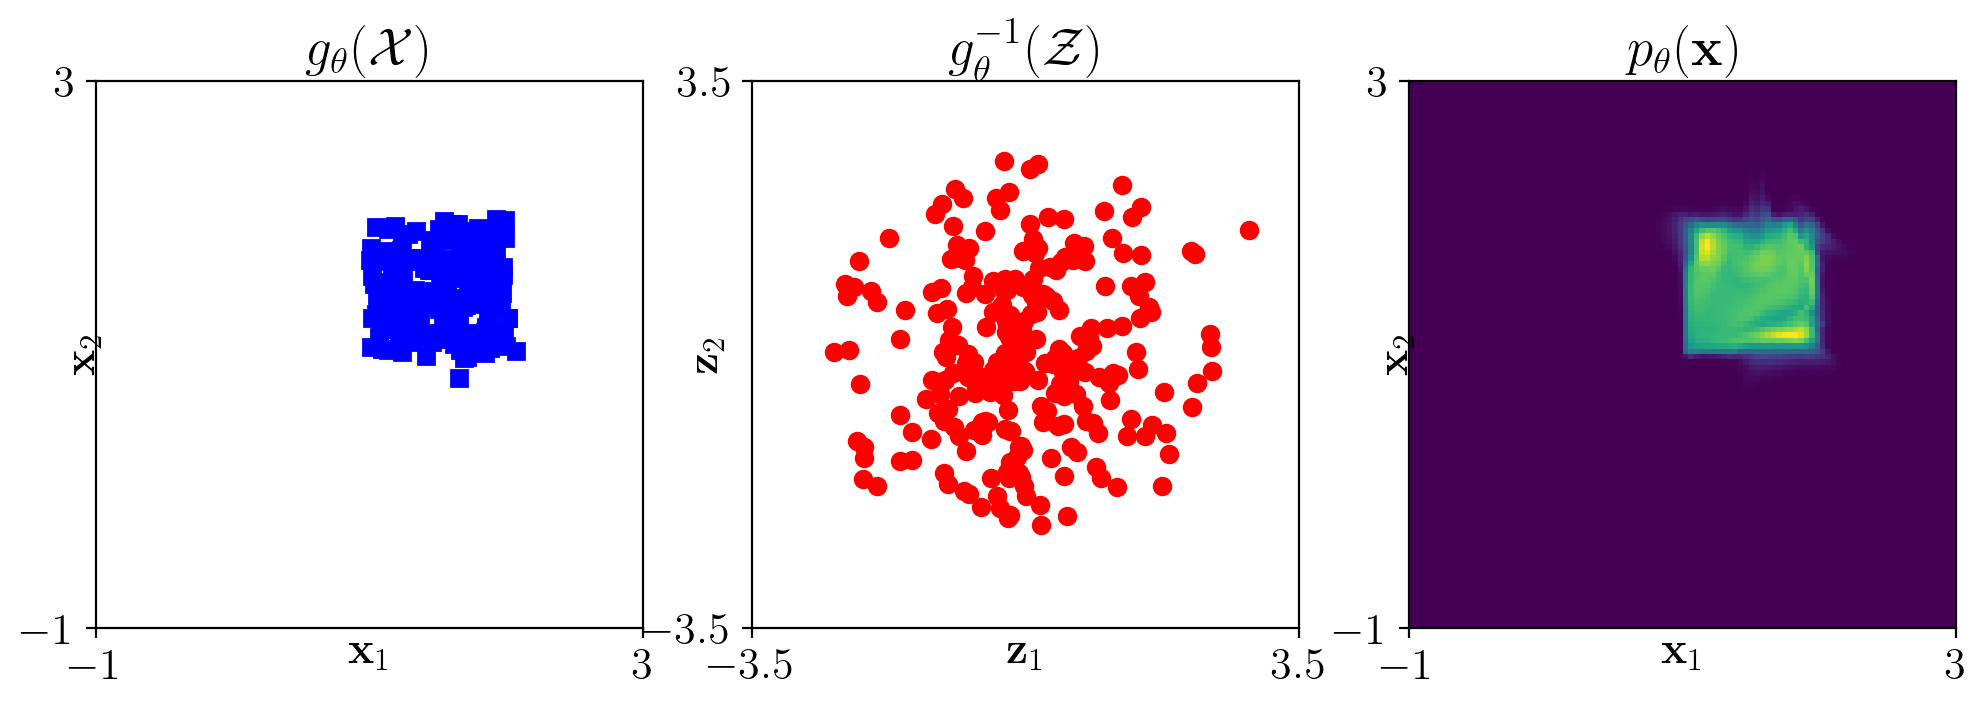

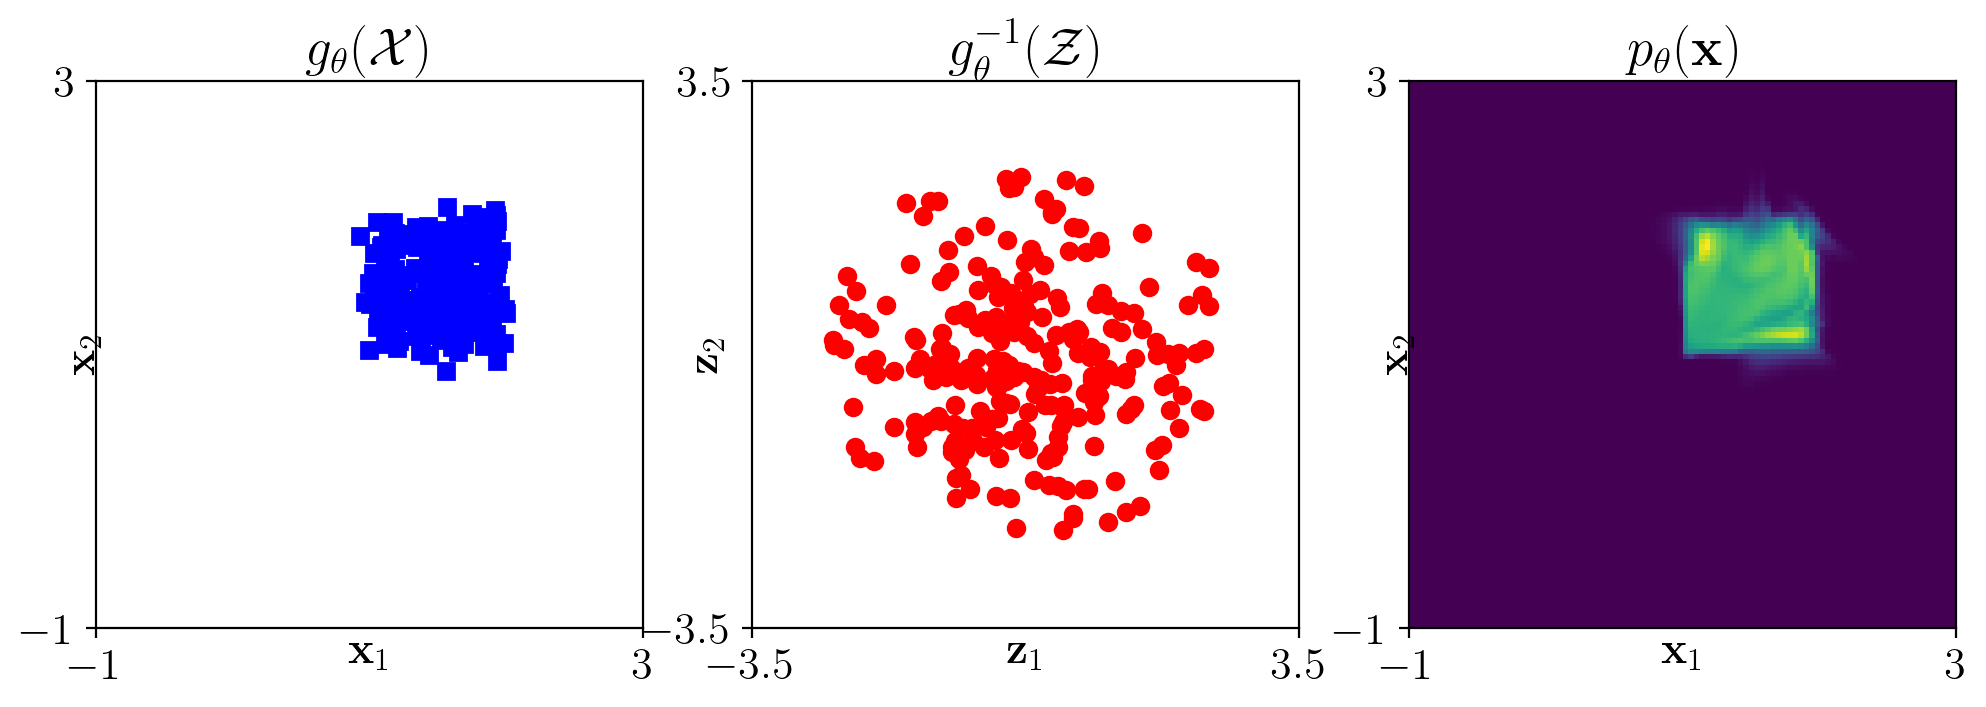

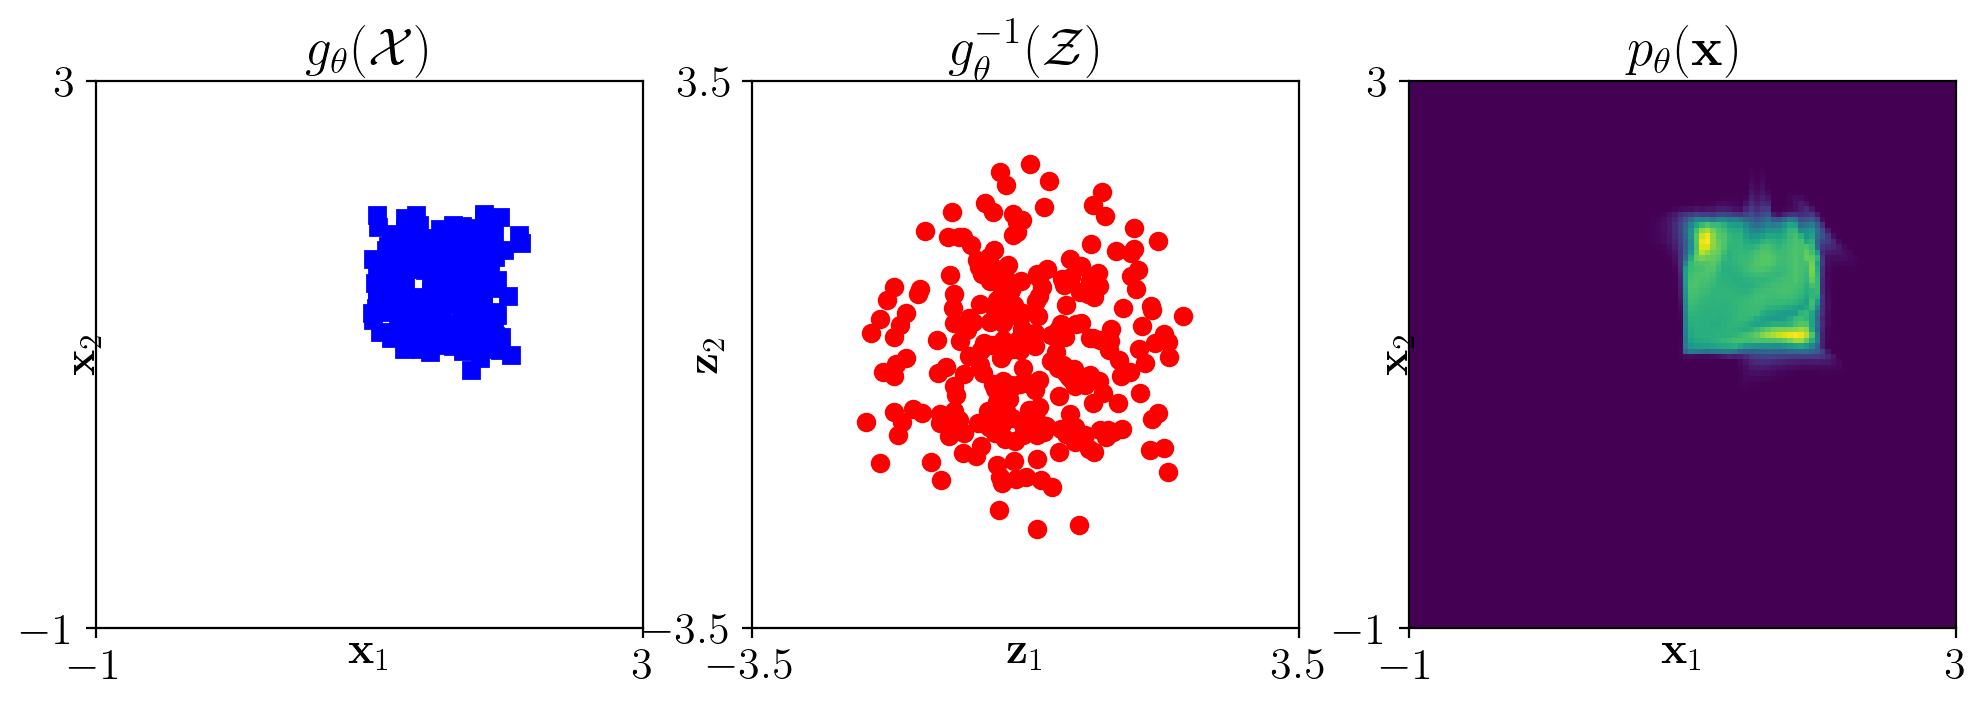

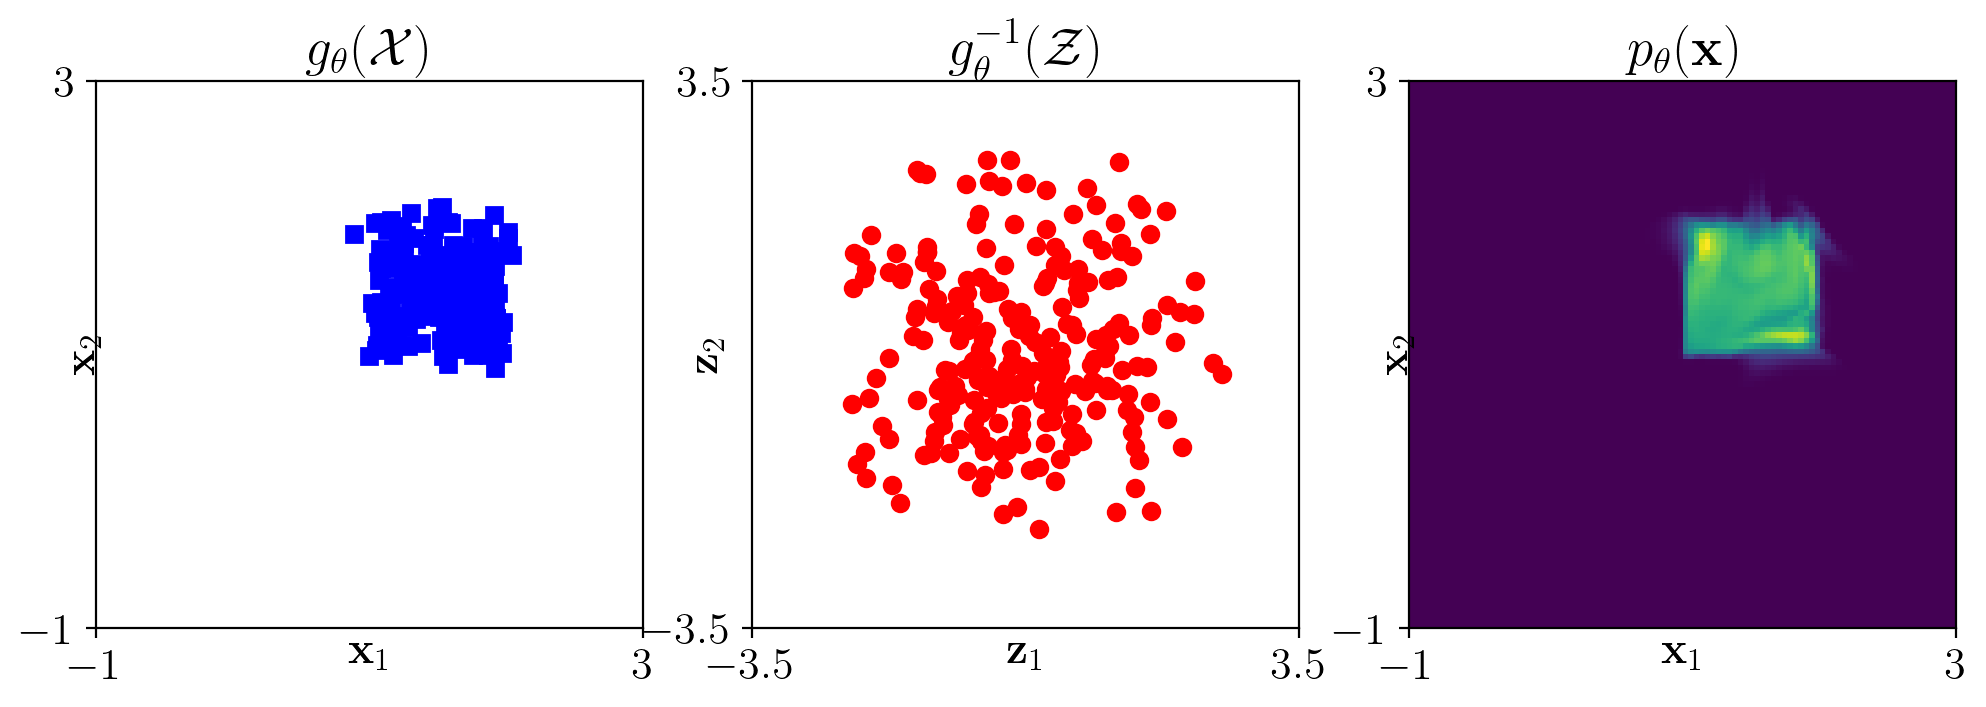

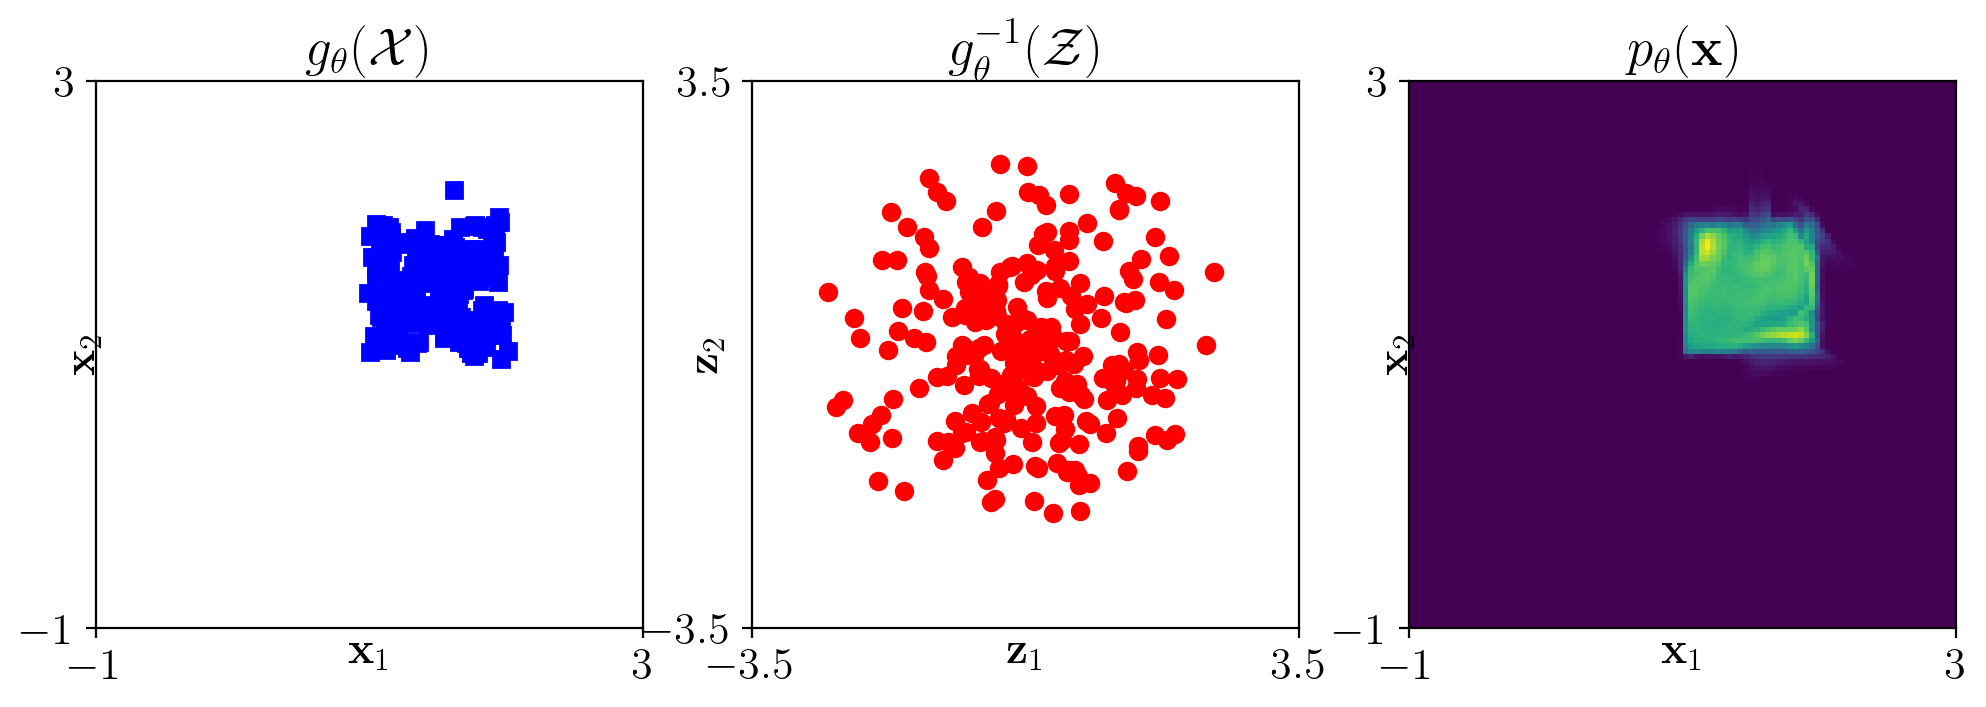

In [27]:
batch_size = 256
num_steps = 10000      # number of training steps
out_file=None          # base filename saving trained model
plot_interval = 1000    # interval for visualizing intermediate results


optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
his = np.zeros((0,1))

print((3*"--" + " K=%d, width=%d, batch_size=%d, num_steps=%d" + 3*"--") % (K, width, batch_size, num_steps, ))

if out_file is not None:
    import os
    out_dir, fname = os.path.split(out_file)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    print((3*"--" + "out_file: %s" + 3*"--") % (out_file))

print((2*"%7s    ") % ("step","J_ML"))

train_JML = 0.0
num_step = 0

for step in range(num_steps):

    x = get_data(batch_size)
    loss = -flow.log_prob(x).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_JML += loss.item()
    num_step += 1

    if (step + 1) % plot_interval == 0:
        train_JML /= num_step

        print(("%06d   " + "%1.4e  ") %
              (step + 1, train_JML))
        his = np.vstack([his, [train_JML]])
        train_JML = 0.0
        num_step = 0


        zs = flow.ginv(x)[0].detach()
        xs = flow.sample(200).detach()
        log_px = flow.log_prob(xx).detach()

        plt.Figure()
        plt.subplot(1,3,1)
        plot_x(xs,domain)
        plt.title("generated samples")

        plt.subplot(1,3,2)
        plot_z(zs)
        plt.title("latent space")

        plt.subplot(1,3,3)
        plot_px(log_px.reshape(len(x1), len(x2)),domain)
        plt.title("likelihood estimate")
        plt.margins(0, 0)
        if out_file is not None:
            plt.savefig("%s-step-%d.png" % (out_file,step+1), bbox_inches='tight', pad_inches=0)
        plt.show()

if out_file is not None:
    torch.save(flow.state_dict(), ("%s.pt") % (out_file))
    from scipy.io import savemat
    savemat(("%s.mat") % (out_file), {"his":his})

## Visualize the Final Result

Compare this to Figure 5 in [https://arxiv.org/abs/2103.05180](https://arxiv.org/abs/2103.05180)

RuntimeError: latex was not able to process the following string:
b'likelihood $p_{\\x08oldsymbol{\\theta}}(\\\\mathbf{x})$ and samples $g_{\\x08oldsymbol{\\theta}}(\\\\mathbf{x})'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/lruthot/.matplotlib/tex.cache/c86bc03cd18d7c539a7fe7c8a3517977.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./c86bc03cd18d7c539a7fe7c8a3517977.aux)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode character ^^H (U+0008)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.19 {\sffamily likelihood $p_{^^H
                                  oldsymbol{	heta}}(\mathbf{x})$ and samples...
No pages of output.
Transcript written on c86bc03cd18d7c539a7fe7c8a3517977.log.




<Figure size 2400x1600 with 3 Axes>

Text(0.5, 1.0, 'hidden layers')

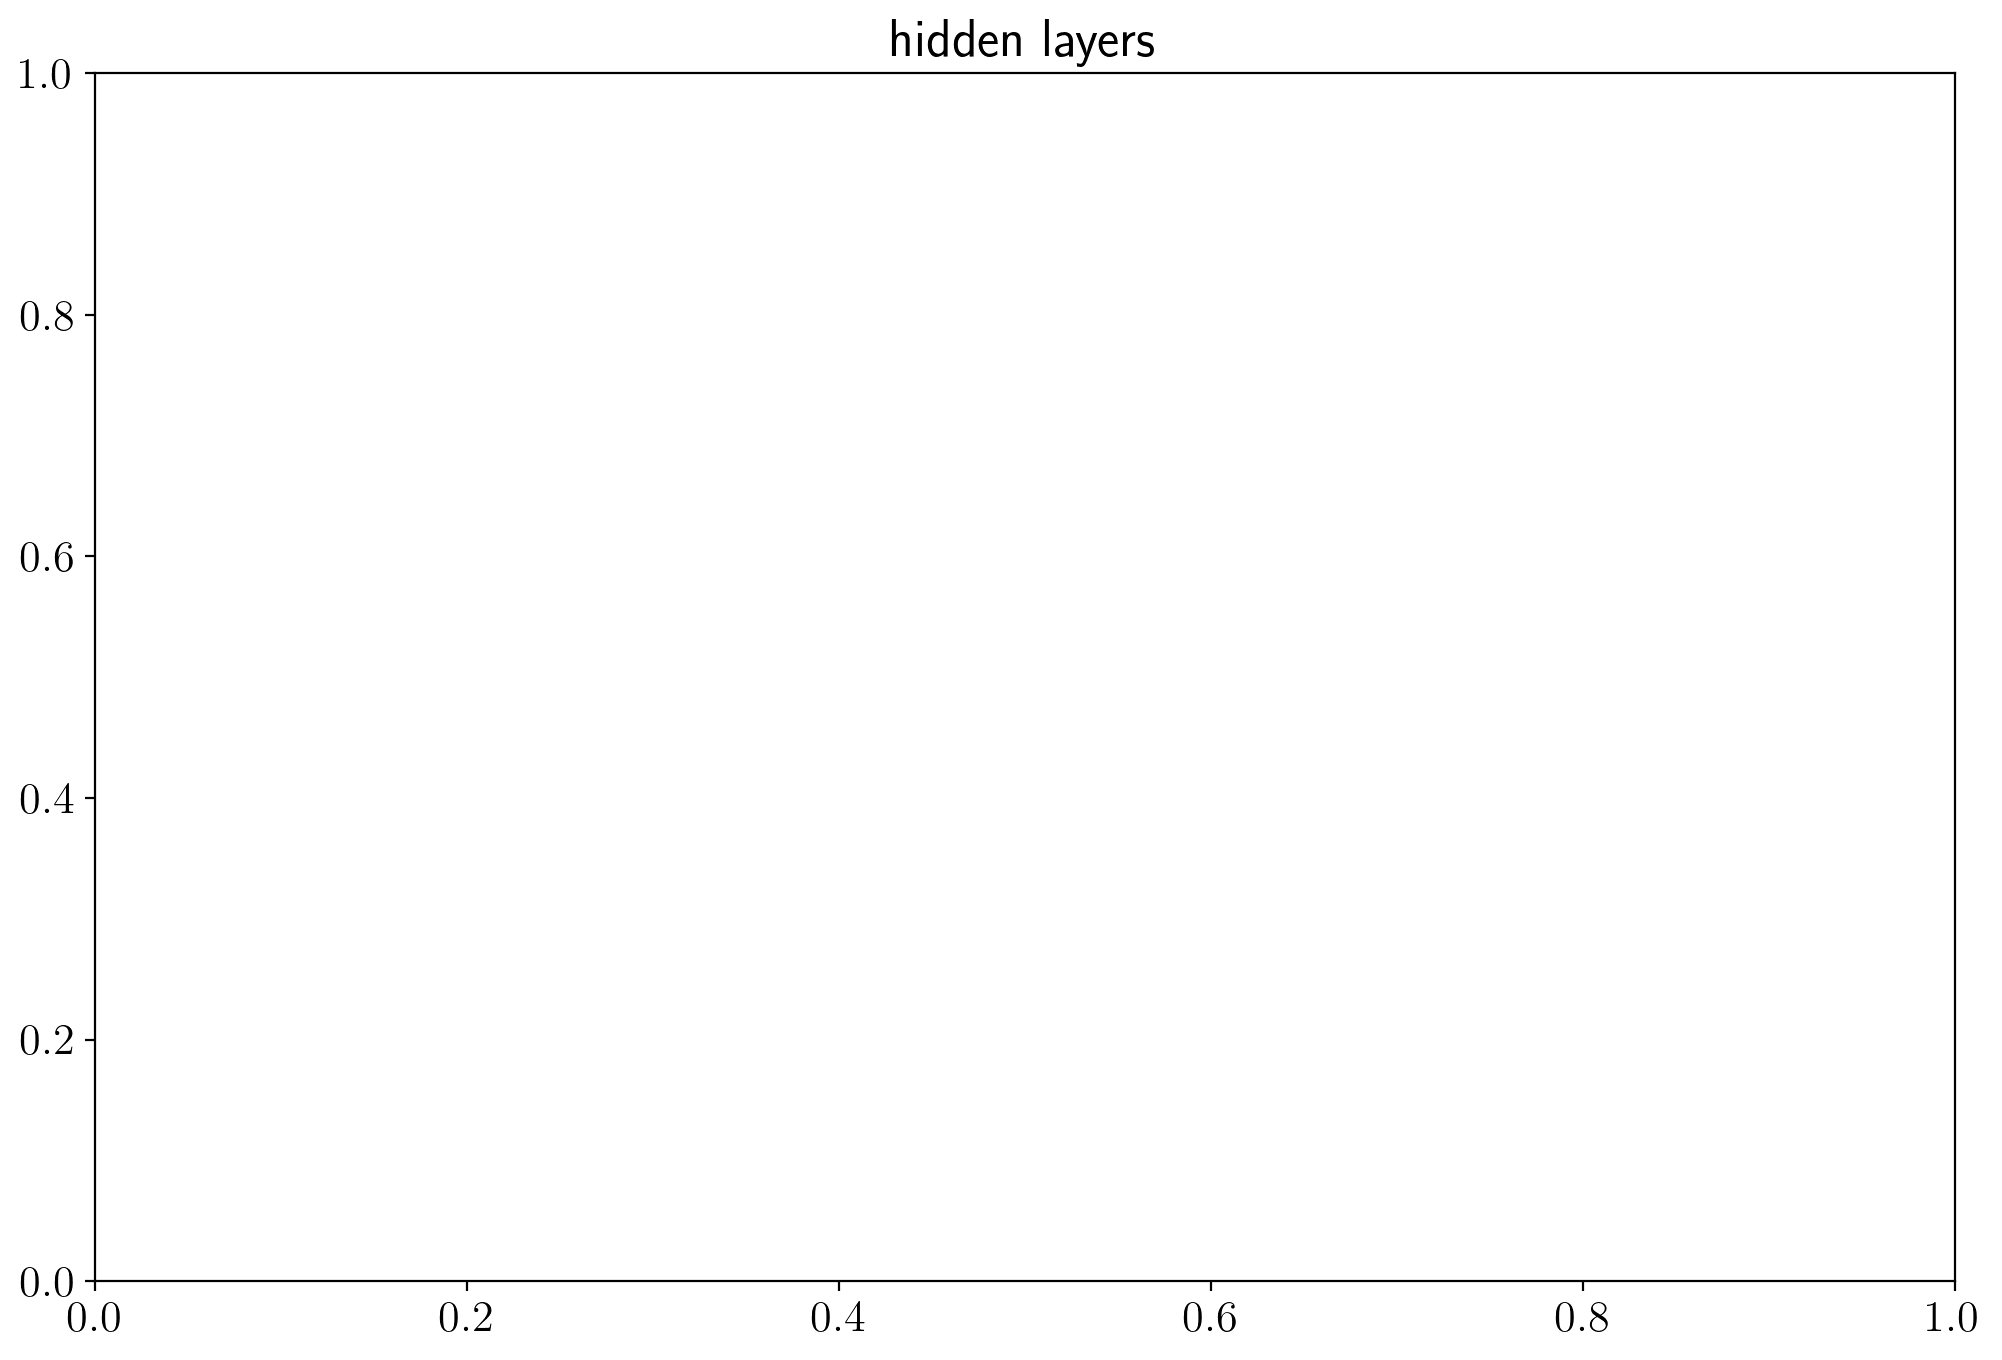

In [28]:
plt.Figure()
plt.subplot(1,3,1)
plot_px(log_px.reshape(len(x1), len(x2)),domain)
plot_x(xs[:64, :],domain)
plt.title("likelihood and samples")

xx = get_data(20000)
zz = flow.ginv(xx)[0].detach().numpy()

plt.subplot(1,3,2)
plot_pz(zz)
plot_z(zs[:64,:])
plt.title("inverse of generator")

zall = torch.cat(flow.ginv(x)[2],1)

plt.subplot(1,3,3)
plt.plot(x[:, 0], x[:, 1], "bs",alpha=0.05)
plt.plot(zs[:, 0], zs[:, 1], "or",alpha=0.05)

for k in range(6):
    zk = zall[k,:].reshape(-1,2)
    plt.plot(zk[:, 0], zk[:, 1], "-xk")
    plt.plot(zk[0, 0], zk[0, 1], "bs")
    plt.plot(zk[-1, 0], zk[-1, 1], "or")

plt.axis("square")
plt.axis((-3.5, 3.5, -3.5, 3.5))
plt.xticks((-3.5, 3.5))
plt.yticks((-3.5, 3.5))
plt.margins(0, 0)
plt.title("hidden layers")